# Chest X-Ray Image Generation using GAN

In [ ]:
# pip install pyhealth

### Load Libraries

In [ ]:
from pyhealth.datasets import split_by_visit, get_dataloader
from pyhealth.trainer import Trainer
from pyhealth.datasets import COVID19CXRDataset
from pyhealth.models import VAE
from pyhealth.processors import ImageProcessor
from torchvision import transforms
from pyhealth.processors import SequenceProcessor

import torch
import numpy as np
import matplotlib.pyplot as plt

/home/ubuntu/PyHealth/pyhealth/trainer.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange
/home/ubuntu/PyHealth/pyhealth/sampler/sage_sampler.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## STEP 1: load the chest Xray data

We also prepare the data:
- resize images to 128x128
- split train/test/validation

In [ ]:
# Download command (uncomment to run)
# !curl -L -o ~/Downloads/covid19-radiography-database.zip https://www.kaggle.com/api/v1/datasets/download/tawsifurrahman/covid19-radiography-database
# !unzip ~/Downloads/covid19-radiography-database.zip -d ~/Downloads/COVID-19_Radiography_Dataset

In [2]:
image_size = 128
covid19cxr_path = "~/Downloads/COVID-19_Radiography_Dataset"

base_dataset = COVID19CXRDataset(covid19cxr_path)

base_dataset.stats()


# Step 2: Set task with custom image processing for GAN
image_processor = ImageProcessor(image_size=image_size, mode="RGB")  # Resize to 128x128 for GAN

sample_dataset = base_dataset.set_task(input_processors={"image": image_processor})

No config path provided, using default config
Initializing covid19_cxr dataset from /home/ubuntu/Downloads/COVID-19_Radiography_Dataset (dev mode: False)
Scanning table: covid19_cxr from /home/ubuntu/Downloads/COVID-19_Radiography_Dataset/covid19_cxr-metadata-pyhealth.csv
Collected dataframe with shape: (21165, 6)
Dataset: covid19_cxr
Dev mode: False
Number of patients: 21165
Number of events: 21165
Setting task COVID19CXRClassification for covid19_cxr base dataset...
Generating samples with 1 worker(s)...


Generating samples for COVID19CXRClassification with 1 worker: 100%|██████████| 21165/21165 [00:08<00:00, 2637.68it/s]

Label disease vocab: {'COVID': 0, 'Lung Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}



Processing samples: 100%|██████████| 21165/21165 [01:18<00:00, 270.15it/s]

Generated 21165 samples for task COVID19CXRClassification


In [ ]:

# split dataset
train_dataset, val_dataset, test_dataset = split_by_visit(
    sample_dataset, [0.8, 0.1, 0.1]
)

train_dataloader = get_dataloader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = get_dataloader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = get_dataloader(test_dataset, batch_size=256, shuffle=False)

data = next(iter(train_dataloader))

print(data["image"][0].shape)

print(
    "loader size: train/val/test",
    len(train_dataset),
    len(val_dataset),
    len(test_dataset),
)

torch.Size([3, 128, 128])
loader size: train/val/test 16932 2116 2117


### STEP3: define the GAN model

In [4]:
from pyhealth.models import GAN

model = GAN(
    input_channel=3,
    input_size=128,
    hidden_dim=256,
)

### STEP4: training the GAN model in an adversarial way

In [5]:
import torch
from tqdm import tqdm

# Loss function
loss = torch.nn.BCELoss()

opt_G = torch.optim.AdamW(model.generator.parameters(), lr=1e-3)
opt_D = torch.optim.AdamW(model.discriminator.parameters(), lr=1e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

curve_D, curve_G = [], []

for epoch in range(50):
    curve_G.append(0)
    curve_D.append(0)
    for batch in tqdm(train_dataloader):
        
        """ train discriminator """
        
        opt_D.zero_grad()
        
        real_imgs = batch["image"].to(device)
        
        batch_size = real_imgs.shape[0]
        
        fake_imgs = model.generate_fake(batch_size, device)
        
        real_loss = loss(model.discriminator(real_imgs), torch.ones(batch_size, 1).to(device))
        fake_loss = loss(model.discriminator(fake_imgs.detach()), torch.zeros(batch_size, 1).to(device))
        loss_D = (real_loss + fake_loss) / 2
        
        loss_D.backward()
        opt_D.step()
        
        """ train generator """
        
        opt_G.zero_grad()
        loss_G = loss(model.discriminator(fake_imgs), torch.ones(batch_size, 1).to(device))
        
        loss_G.backward()
        opt_G.step()
        
        curve_G[-1] += loss_G.item()
        curve_D[-1] += loss_D.item()
        
    print(f"epoch: {epoch} --- loss of G: {curve_G[-1]}, loss of D: {curve_D[-1]}")

100%|██████████| 67/67 [00:07<00:00,  9.02it/s]


epoch: 0 --- loss of G: 187.00772655010223, loss of D: 17.679536825045943


100%|██████████| 67/67 [00:06<00:00, 10.70it/s]


epoch: 1 --- loss of G: 421.60688638687134, loss of D: 0.9925004122778773


100%|██████████| 67/67 [00:06<00:00, 10.57it/s]


epoch: 2 --- loss of G: 510.64223623275757, loss of D: 0.3214332648785785


100%|██████████| 67/67 [00:06<00:00, 10.63it/s]


epoch: 3 --- loss of G: 567.562891960144, loss of D: 0.15068832962424494


100%|██████████| 67/67 [00:06<00:00, 10.35it/s]


epoch: 4 --- loss of G: 599.3213233947754, loss of D: 0.08608292078133672


100%|██████████| 67/67 [00:06<00:00, 10.19it/s]


epoch: 5 --- loss of G: 588.9778165817261, loss of D: 0.12099041216424666


100%|██████████| 67/67 [00:07<00:00,  8.99it/s]


epoch: 6 --- loss of G: 603.5574598312378, loss of D: 0.12727271695621312


100%|██████████| 67/67 [00:06<00:00, 10.30it/s]


epoch: 7 --- loss of G: 639.0430097579956, loss of D: 0.1332307325792499


100%|██████████| 67/67 [00:13<00:00,  5.15it/s]


epoch: 8 --- loss of G: 651.0378975868225, loss of D: 0.9335501801688224


100%|██████████| 67/67 [02:29<00:00,  2.23s/it]


epoch: 9 --- loss of G: 616.8124380111694, loss of D: 3.84032856952399


100%|██████████| 67/67 [03:13<00:00,  2.89s/it]


epoch: 10 --- loss of G: 519.6118609905243, loss of D: 9.224071164149791


100%|██████████| 67/67 [01:48<00:00,  1.62s/it]


epoch: 11 --- loss of G: 562.777735710144, loss of D: 3.7825616598129272


100%|██████████| 67/67 [00:06<00:00, 10.87it/s]


epoch: 12 --- loss of G: 336.34571504592896, loss of D: 20.344450883567333


100%|██████████| 67/67 [00:06<00:00, 11.03it/s]


epoch: 13 --- loss of G: 294.52232551574707, loss of D: 19.83913780748844


100%|██████████| 67/67 [00:06<00:00, 10.38it/s]


epoch: 14 --- loss of G: 140.42432856559753, loss of D: 39.276702120900154


100%|██████████| 67/67 [00:06<00:00, 10.78it/s]


epoch: 15 --- loss of G: 99.24431133270264, loss of D: 38.27878451347351


100%|██████████| 67/67 [00:06<00:00, 10.40it/s]


epoch: 16 --- loss of G: 81.83258920907974, loss of D: 40.19685423374176


100%|██████████| 67/67 [00:06<00:00, 10.40it/s]


epoch: 17 --- loss of G: 83.60888206958771, loss of D: 40.768057465553284


100%|██████████| 67/67 [00:06<00:00, 10.80it/s]


epoch: 18 --- loss of G: 96.50049769878387, loss of D: 36.23655703663826


100%|██████████| 67/67 [00:06<00:00, 10.50it/s]


epoch: 19 --- loss of G: 105.58138465881348, loss of D: 35.10594001412392


100%|██████████| 67/67 [00:06<00:00, 10.88it/s]


epoch: 20 --- loss of G: 114.39195239543915, loss of D: 32.3329062461853


100%|██████████| 67/67 [00:06<00:00, 10.81it/s]


epoch: 21 --- loss of G: 101.80236661434174, loss of D: 38.6760116815567


100%|██████████| 67/67 [00:06<00:00, 10.57it/s]


epoch: 22 --- loss of G: 109.04553139209747, loss of D: 32.825062185525894


100%|██████████| 67/67 [00:06<00:00, 10.60it/s]


epoch: 23 --- loss of G: 123.76316118240356, loss of D: 30.759442001581192


100%|██████████| 67/67 [00:06<00:00, 10.36it/s]


epoch: 24 --- loss of G: 105.20807480812073, loss of D: 36.456340968608856


100%|██████████| 67/67 [00:06<00:00, 10.38it/s]


epoch: 25 --- loss of G: 137.6276512145996, loss of D: 25.502176865935326


100%|██████████| 67/67 [00:06<00:00, 10.41it/s]


epoch: 26 --- loss of G: 149.49159610271454, loss of D: 28.30062609910965


100%|██████████| 67/67 [00:06<00:00, 10.40it/s]


epoch: 27 --- loss of G: 145.72875905036926, loss of D: 31.580776512622833


100%|██████████| 67/67 [00:06<00:00, 10.45it/s]


epoch: 28 --- loss of G: 130.92576503753662, loss of D: 32.87881879508495


100%|██████████| 67/67 [00:06<00:00, 10.80it/s]


epoch: 29 --- loss of G: 131.46568083763123, loss of D: 31.840122565627098


100%|██████████| 67/67 [00:06<00:00, 10.37it/s]


epoch: 30 --- loss of G: 84.15838372707367, loss of D: 42.73091375827789


100%|██████████| 67/67 [00:06<00:00, 10.69it/s]


epoch: 31 --- loss of G: 74.97820204496384, loss of D: 40.54647704958916


100%|██████████| 67/67 [00:06<00:00, 10.68it/s]


epoch: 32 --- loss of G: 101.26055026054382, loss of D: 29.263713508844376


100%|██████████| 67/67 [00:06<00:00, 10.31it/s]


epoch: 33 --- loss of G: 86.86687338352203, loss of D: 37.598598927259445


100%|██████████| 67/67 [00:06<00:00, 10.75it/s]


epoch: 34 --- loss of G: 84.66891765594482, loss of D: 40.19908273220062


100%|██████████| 67/67 [00:06<00:00, 10.33it/s]


epoch: 35 --- loss of G: 79.72011703252792, loss of D: 41.72318208217621


100%|██████████| 67/67 [00:06<00:00, 10.59it/s]


epoch: 36 --- loss of G: 73.43266141414642, loss of D: 40.948941975831985


100%|██████████| 67/67 [00:06<00:00, 10.75it/s]


epoch: 37 --- loss of G: 72.37873077392578, loss of D: 41.60090494155884


100%|██████████| 67/67 [00:06<00:00, 10.73it/s]


epoch: 38 --- loss of G: 61.18730026483536, loss of D: 44.2846662402153


100%|██████████| 67/67 [00:06<00:00, 10.48it/s]


epoch: 39 --- loss of G: 62.92646849155426, loss of D: 43.42814892530441


100%|██████████| 67/67 [00:06<00:00, 10.75it/s]


epoch: 40 --- loss of G: 70.7225307226181, loss of D: 38.10763677954674


100%|██████████| 67/67 [00:06<00:00, 10.27it/s]


epoch: 41 --- loss of G: 79.05009615421295, loss of D: 38.92615833878517


100%|██████████| 67/67 [00:06<00:00, 10.65it/s]


epoch: 42 --- loss of G: 77.47582876682281, loss of D: 37.80526325106621


100%|██████████| 67/67 [00:06<00:00, 10.84it/s]


epoch: 43 --- loss of G: 89.28383368253708, loss of D: 36.453640162944794


100%|██████████| 67/67 [00:06<00:00, 10.69it/s]


epoch: 44 --- loss of G: 83.84232759475708, loss of D: 39.26784712076187


100%|██████████| 67/67 [00:06<00:00, 10.62it/s]


epoch: 45 --- loss of G: 86.17833715677261, loss of D: 37.44430324435234


100%|██████████| 67/67 [00:06<00:00, 10.55it/s]


epoch: 46 --- loss of G: 88.58943152427673, loss of D: 35.40870875120163


100%|██████████| 67/67 [00:06<00:00, 10.76it/s]


epoch: 47 --- loss of G: 88.73302459716797, loss of D: 36.97438296675682


100%|██████████| 67/67 [00:06<00:00, 10.50it/s]


epoch: 48 --- loss of G: 71.31993687152863, loss of D: 44.25900250673294


100%|██████████| 67/67 [00:06<00:00, 10.71it/s]

epoch: 49 --- loss of G: 70.42304891347885, loss of D: 37.90644350647926


### EXP 2: synthesize random images

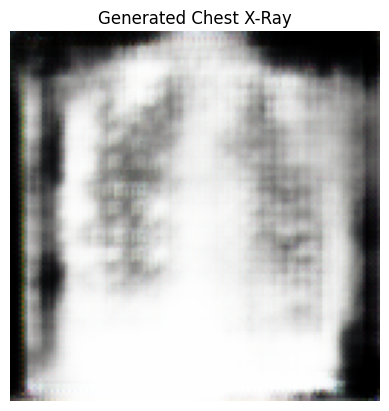

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    fake_imgs = model.generate_fake(1, device).detach().cpu()
    plt.imshow(fake_imgs[0].permute(1, 2, 0).clamp(0, 1))  # RGB image
    plt.title("Generated Chest X-Ray")
    plt.axis('off')
    plt.show()